<a href="https://colab.research.google.com/github/klariewu330/CIS9650_Group16_Project_11/blob/main/CIS9650_Group16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of NYC Green Taxi Trip Data

### Author: Jiahuan Wu, Tenzin Sonam, Nuzhat Shahriyar, Humaza Ali
### Date: Dec. 12th 2025


## Executive Summary

## Introduction
Taxis remain a crucial part of urban transportation in New York City, particularly in areas underserved by public transit. Understanding patterns in passenger trips, fare structures, tipping behavior, and trip timing can provide valuable insights for taxi operators, policy makers, and ride-hailing services. This project analyzes NYC Green Taxi trip data to uncover key trends and evaluate relationships affecting revenue and rider behavior.


## Problem Statement
The primary objective of this analysis is to determine how trip characteristics, such as distance, duration, and time of travel, affect fare amount and tipping behavior. Specifically, this study aims to answer the following questions:

## Data Description
Dataset Size:
- Number of rows: 47006
- Number of columns: 22



## Setup and Environment

In [5]:
!pip install google-cloud-storage

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO

In [7]:
#required to read Parquet files
!pip install pandas pyarrow

## Data Loading

In [8]:
#open and import the file
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    print(f"Listing files in public bucket '{bucket_name}' under '{prefix}':")
    filenames = []
    for blob in blobs:
        print(blob.name)
        filenames.append(blob.name)

    return filenames

In [4]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Detect file extension
    _, ext = os.path.splitext(blob_path.lower())

    if ext == ".csv":
        df = pd.read_csv(BytesIO(data))

    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(BytesIO(data))

    elif ext == ".parquet":
        df = pd.read_parquet(BytesIO(data))

    elif ext == ".json":
        # Convert bytes → Python object
        text = data.decode("utf-8")
        json_obj = json.loads(text)

        # If JSON is a list → NORMAL DataFrame
        if isinstance(json_obj, list):
            df = pd.DataFrame(json_obj)

        # If JSON is a dict → flatten into rows
        elif isinstance(json_obj, dict):
            df = pd.json_normalize(json_obj)

        else:
            raise ValueError("Unsupported JSON structure")

    else:
        raise ValueError(f"Unsupported file type: {ext}")

    return df

In [9]:
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "11"
COURSE = "CIS9650"
salaries_raw = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

Listing files in public bucket 'msba-online-data' under 'CIS9650/Project 11/':
CIS9650/Project 11/
CIS9650/Project 11/green_tripdata_2025-06.parquet


In [11]:
try:
  url = "https://storage.googleapis.com/msba-online-data/CIS9650/Project%2011/green_tripdata_2025-06.parquet"
  df = pd.read_parquet(url, engine='pyarrow')
  print(df.head())
  print("Data Loaded Successfully ")

except Exception as e:
  print(f"Error loading the file: {e}")

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2025-06-01 00:33:43   2025-06-01 01:04:33                  N   
1         2  2025-06-01 00:07:45   2025-06-01 00:14:52                  N   
2         2  2025-06-01 00:24:07   2025-06-01 00:48:24                  N   
3         2  2025-06-01 00:00:14   2025-06-01 00:08:29                  N   
4         2  2025-06-01 00:31:15   2025-06-01 00:43:35                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         2.0            74           132              1.0          19.60   
1         1.0            75            74              2.0           1.37   
2         1.0            83            83              1.0           4.11   
3         1.0            97            49              1.0           1.29   
4         1.0            66            25              1.0           1.97   

   fare_amount  ...  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0    

##Data Preperation

In [12]:
# Calculate Trip Duration

# Convert string to actual datetime
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

# Calculate trip duration in minutes
df['trip_duration_min'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# remove negative or zero durations
df = df[df['trip_duration_min'] > 0]

# Format to 2 decimal places
df['trip_duration_min'] = df['trip_duration_min'].round(2)

print(df[['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_duration_min']].head())

  lpep_pickup_datetime lpep_dropoff_datetime  trip_duration_min
0  2025-06-01 00:33:43   2025-06-01 01:04:33              30.83
1  2025-06-01 00:07:45   2025-06-01 00:14:52               7.12
2  2025-06-01 00:24:07   2025-06-01 00:48:24              24.28
3  2025-06-01 00:00:14   2025-06-01 00:08:29               8.25
4  2025-06-01 00:31:15   2025-06-01 00:43:35              12.33


In [ ]:

# Outlier Detection (Before Cleaning)
print("----- OUTLIERS BEFORE CLEANING -----")
print("Trips with duration less than 0 minutes:", (df['trip_duration_min'] <= 0).sum())
print("Trips longer than 3 hours:", (df['trip_duration_min'] > 180).sum())
print("Rows with negative tip:", (df['tip_amount'] < 0).sum())
print("Rows with tip over $50:", (df['tip_amount'] > 50).sum())
print("Rows with negative fare:", (df['fare_amount'] < 0).sum())
print("Rows with fare over $250:", (df['fare_amount'] > 250).sum())
print("Trips with distance less than 0 miles:", (df['trip_distance'] <= 0).sum())
print("Trips with distance above 50 miles:", (df['trip_distance'] > 50).sum())


# Data Cleaning
# Handling Invalid Durations
df = df[df['trip_duration_min'] > 0].copy()

# Remove unrealistically long trips (>180 minutes)
df = df[df['trip_duration_min'] <= 180].copy()

# Remove negative and extreme tips
df = df[(df['tip_amount'] >= 0) & (df['tip_amount'] <= 50)].copy()

# Remove negative and excessive fares
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 250)].copy()

# Remove invalid and extreme trip distances
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 50)].copy()

# Validation (After Cleaning)
print("\n----- AFTER CLEANING -----")
print("Trips with duration less than 0 minutes:", (df['trip_duration_min'] <= 0).sum())
print("Trips longer than 3 hours:", (df['trip_duration_min'] > 180).sum())
print("Rows with negative tip:", (df['tip_amount'] < 0).sum())
print("Rows with tip over $50:", (df['tip_amount'] > 50).sum())
print("Rows with negative fare:", (df['fare_amount'] < 0).sum())
print("Rows with fare over $250:", (df['fare_amount'] > 250).sum())
print("Trips with distance less than 0 miles:", (df['trip_distance'] <= 0).sum())
print("Trips with distance above 50 miles:", (df['trip_distance'] > 50).sum())

----- OUTLIERS BEFORE CLEANING -----
Trips with duration less than 0 minutes: 0
Trips longer than 3 hours: 180
Rows with negative tip: 2
Rows with tip over $50: 19
Rows with negative fare: 156
Rows with fare over $250: 19
Trips with distance less than 0 miles: 1774
Trips with distance above 50 miles: 15

----- AFTER CLEANING -----
Trips with duration less than 0 minutes: 0
Trips longer than 3 hours: 0
Rows with negative tip: 0
Rows with tip over $50: 0
Rows with negative fare: 0
Rows with fare over $250: 0
Trips with distance less than 0 miles: 0
Trips with distance above 50 miles: 0


##Model Planning


In [ ]:
# Most Popular Pick-Up Location
def most_pop_PULocation(id):
  location = id
  print("Hello")
print("Hello")

Hello


In [ ]:
# 2. Find peak days and peak hours
# Ensure datetime conversion
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')

# Extract hour, day of week (0=Monday)
df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()
df['pickup_month'] = df['lpep_pickup_datetime'].dt.month_name()

#Find peak hours
peak_hours = df['pickup_hour'].value_counts().sort_index()
print("Trips per Hour:")
print(peak_hours)

peak_hour = peak_hours.idxmax()
peak_hour_count = peak_hours.max()
print(f"\nPeak Pickup Hour is {peak_hour}:00 with {peak_hour_count} trips")


#Find peak days
peak_days = df['pickup_day'].value_counts()
print("\nTrips per Day of Week:")
print(peak_days)

peak_day = peak_days.idxmax()
peak_day_count = peak_days.max()
print(f"\nPeak Pickup Day is {peak_day} with {peak_day_count} trips")

Trips per Hour:
pickup_hour
0      902
1      520
2      371
3      268
4      268
5      329
6      786
7     1726
8     2384
9     2556
10    2535
11    2408
12    2736
13    2624
14    2932
15    3082
16    3550
17    3706
18    3530
19    2834
20    1964
21    1990
22    1692
23    1313
Name: count, dtype: int64

Peak Pickup Hour is 17:00 with 3706 trips

Trips per Day of Week:
pickup_day
Monday       8097
Wednesday    7015
Sunday       6727
Tuesday      6727
Thursday     6714
Friday       6255
Saturday     5471
Name: count, dtype: int64

Peak Pickup Day is Monday with 8097 trips


Peak Hours: Taxi demand increases sharply starting at 3 PM, peaking at 5,6 PM,
with 5 PM recording the highest number of trips (3,550).

Peak Days of the Week: Monday shows the most trips (8,097), followed by Wednesday (7,015).

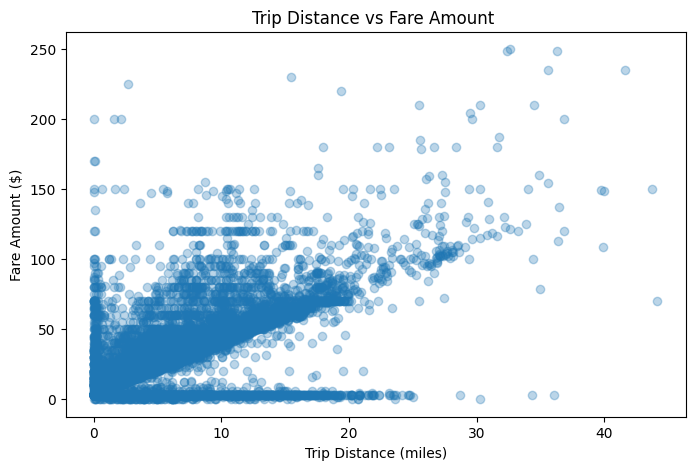

In [ ]:
# 3. Does fare increase linearly with trip distance?
plt.figure(figsize=(8,5))
plt.scatter(df['trip_distance'], df['fare_amount'], alpha=0.3)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.title("Trip Distance vs Fare Amount ")
plt.show()


In [ ]:
# Revenue by hour, day, location

df2 = df.copy()

# Extracting hour and day of the week
df2["datetime"] = pd.to_datetime(df2["lpep_pickup_datetime"])
df2["hour"] = df2["datetime"].dt.hour
df2["day_of_week"] = df2["datetime"].dt.day_name()


# Revenue by hour
revenue_hour = df2.groupby("hour")["total_amount"].sum()

# Revenue by day
revenue_day = df2.groupby("day_of_week")["total_amount"].sum()

# Revenue by pick-up location
revenue_loc = df2.groupby("PULocationID")["total_amount"].sum()

print(f"Revenue by Hour: \n{revenue_hour}")
print(f"Revenue by Day of Week: \n{revenue_day}")
print(f"Revenue by Pick-Up Location: \n{revenue_loc}")
print(f"The highest revenue PULocation: {revenue_loc.idxmax()} - {revenue_loc.max()}" )


Revenue by Hour: 
hour
0     29059.33
1     16117.66
2     14272.84
3     10903.60
4     12294.83
5     12312.46
6     21133.10
7     44127.07
8     62383.68
9     65588.24
10    63493.85
11    63070.96
12    69452.31
13    66680.58
14    77184.10
15    75728.72
16    95664.59
17    96606.71
18    87184.49
19    68491.07
20    52315.24
21    63738.08
22    64165.15
23    42170.38
Name: total_amount, dtype: float64
Revenue by Day of Week: 
day_of_week
Friday       172615.41
Monday       207413.67
Saturday     152468.61
Sunday       185630.11
Thursday     183980.27
Tuesday      178249.84
Wednesday    193781.13
Name: total_amount, dtype: float64
Revenue by Pick-Up Location: 
PULocationID
3        489.85
4        102.70
7      12806.51
9        141.87
10       876.13
         ...   
261      175.51
262      219.98
263     1495.41
264     2760.45
265     3170.47
Name: total_amount, Length: 232, dtype: float64
The highest revenue PULocation: 74 - 268271.62


On average revenue peaked at hour 17, between 5pm and 6pm.

Monday resulted as the highest revenue day.

Pick-Up Location 74 observed the highest revenue compared to other locations.

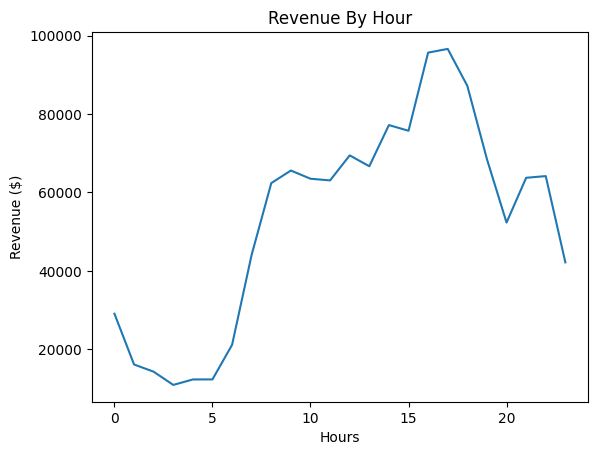

In [ ]:
# Graphing Revenue By Hour
plt.plot(revenue_hour.index, revenue_hour.values)
plt.title("Revenue By Hour")
plt.xlabel("Hours")
plt.ylabel("Revenue ($)")
plt.show()

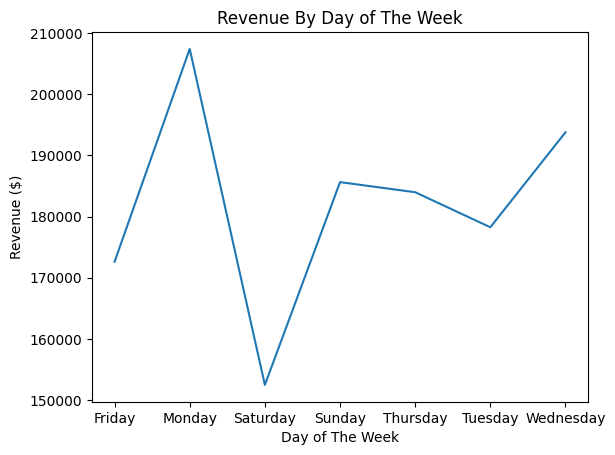

In [ ]:
# Graphing Revenue By Day of Week

plt.plot(revenue_day.index, revenue_day.values)
plt.title("Revenue By Day of The Week")
plt.xlabel("Day of The Week")
plt.ylabel("Revenue ($)")
plt.show()

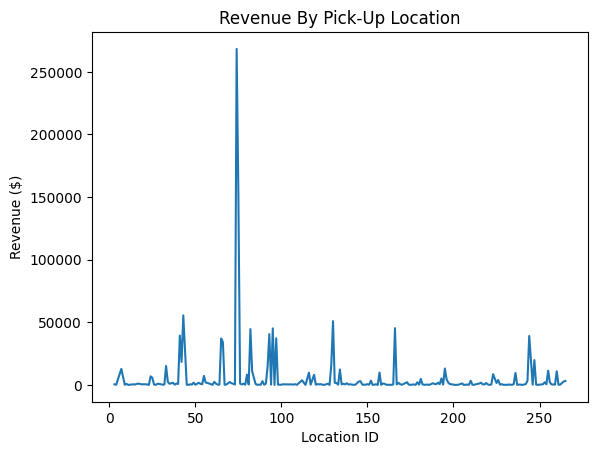

In [ ]:
# Graphing Revenue by Pick-Up Location
plt.plot(revenue_loc.index, revenue_loc.values)
plt.title("Revenue By Pick-Up Location")
plt.xlabel("Location ID")
plt.ylabel("Revenue ($)")
plt.show()

In [ ]:
# Most popular route
routes = df[df["PULocationID"] == df[""]]

## Model Analysis

## Discussion and Results

##Conclusion